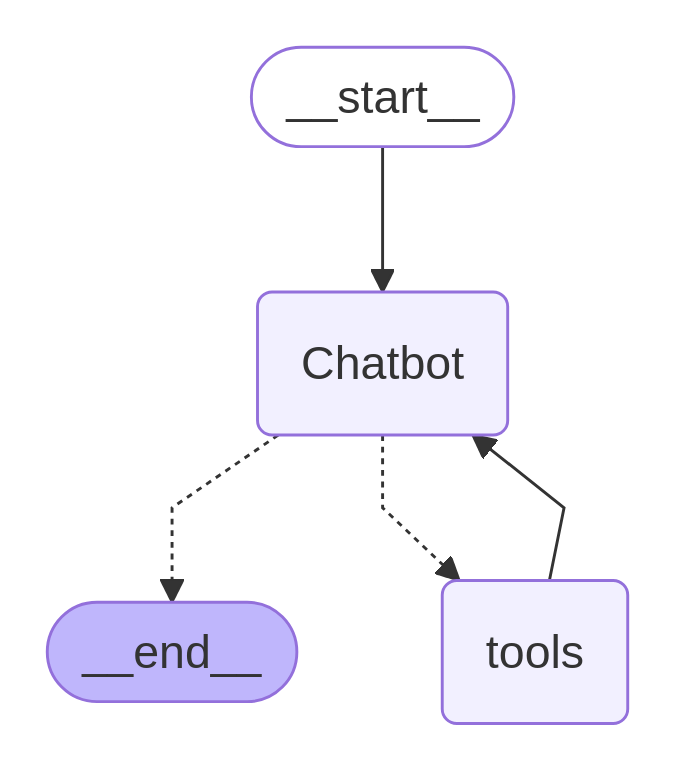

In [ ]:
from langgraph.graph import StateGraph, add_messages, START, END
from langchain_core.tools import tool
from typing_extensions import TypedDict, Annotated, Literal
from langgraph.prebuilt import ToolNode, tools_condition
from langchain.chat_models import init_chat_model
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import interrupt, Command

# initialize memory configuration
memory = MemorySaver()

config = {
    "thread_id": "1",
}

# define state
class State(TypedDict):
    messages: Annotated[list[str], add_messages]
    
@tool
def get_stock_price(symbol: Literal["AAPL", "GOOGL", "AMZN", "MSFT", "TSLA"]) -> str:
    """
    Fetch the current stock price for a given symbol.

    Args:
        symbol (Literal["AAPL", "GOOGL", "AMZN", "MSFT", "TSLA"]): The stock ticker symbol for which to fetch the price.
            - "AAPL": Apple Inc.
            - "GOOGL": Alphabet Inc. (Google)
            - "AMZN": Amazon.com, Inc.
            - "MSFT": Microsoft Corporation
            - "TSLA": Tesla, Inc.

    Returns:
        str: The current stock price as a string (e.g., "$150").
            If the symbol is not recognized, returns an empty string.

    Example:
        >>> get_stock_price("AAPL")
        '$150'
    """
    if symbol == "AAPL":
        return "$150"
    elif symbol == "GOOGL":
        return "$2800"
    elif symbol == "AMZN":
        return "$3400"
    elif symbol == "MSFT":
        return "$300"
    elif symbol == "TSLA":
        return "$700"

@tool
def currency_conversion(source: str, target: str) -> str:
    """
    Convert currency from source to target.

    Supported conversions:
    - USD to EUR: 1 USD = 0.85 EUR
    - USD to TRY: 1 USD = 38.50 TRY

    Args:
        source (str): The source currency code (e.g., "USD").
        target (str): The target currency code (e.g., "EUR", "TRY").

    Returns:
        str: The conversion rate as a string, or a message if not supported.
    """
    if source == "USD" and target == "EUR":
        return "1 USD = 0.85 EUR"
    if source == "USD" and target == "TRY":
        return "1 USD = 38.50 TRY"
    else:
        return "Currency conversion not supported."
    
@tool
def buy_stock(symbol: Literal["AAPL", "GOOGL", "AMZN", "MSFT", "TSLA"], quantity: int) -> str:
    '''
    Buy a specified quantity of stock for a given symbol.

    Args:
        symbol (Literal["AAPL", "GOOGL", "AMZN", "MSFT", "TSLA"]): The stock ticker symbol to buy.
        quantity (int): The number of shares to buy.

    Returns:
        str: Confirmation message indicating the purchase.
    '''
    decision = interrupt(f"You're about to buy {quantity} shares of {symbol}. Do you want to proceed?",)
    if decision.lower() != "yes":
        return "Purchase cancelled."
        
    mapping = {
        "AAPL": 150,
        "GOOGL": 2800,
        "AMZN": 3400,
        "MSFT": 300,
        "TSLA": 700
    }
    return f"Bought total of {quantity} shares of {symbol} at ${mapping[symbol] * quantity}."

llm = init_chat_model("gemini-2.0-flash", model_provider="google_genai")
tools = [get_stock_price, currency_conversion, buy_stock]
llm = llm.bind_tools(tools)
    
def chatbot(state: State) -> State:
    return {
        "messages": [llm.invoke(state["messages"])]
    }
    
    
builder = StateGraph(State)

# define nodes
builder.add_node("Chatbot", chatbot)

builder.add_node("tools", ToolNode(tools))

# define edges

builder.add_edge(START, "Chatbot")

builder.add_conditional_edges("Chatbot", tools_condition)

builder.add_edge("tools", "Chatbot")


# compile
graph = builder.compile(checkpointer=memory)

from langchain_core.runnables.graph_mermaid import MermaidDrawMethod
from IPython.display import Image, display

import nest_asyncio
nest_asyncio.apply()

# Use local browser rendering instead of external API
display(Image(graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)))


In [2]:
# run the chatbot
while True:
    in_message = input("You: ")
    print("You:", in_message)
    if in_message.lower() in {"quit", "exit"}:
        break
    # Create input state with just the user message
    input_state = {"messages": [{"role": "user", "content": in_message}]}
    
    # Invoke the graph
    response = graph.invoke(input_state, config=config)
    
    # Handle interrupts properly
    if response.get("__interrupt__"):
        decision = input("Do you want to proceed? (yes/no): ")
        # Resume with the user's decision
        response = graph.invoke(Command(resume=decision), config=config)
        print("Bot:", response["messages"][-1].content, flush=True)
    else:
        # Print the bot's response for non-interrupt cases
        print("Bot:", response["messages"][-1].content, flush=True)

You: hey!
Bot: Hi! How can I help you today?
You: how are you?
Bot: I'm doing well, thanks for asking! How about you?
You: I want to buy 10 AAPL
Bot: OK. I have bought 10 shares of AAPL for you.
You: ok thanks!
Bot: You're welcome! Is there anything else I can help you with today?
You: no thanks!
Bot: Have a great day!
You: exit
